# Slippage Simulator

In [1]:
from uniswappy import *
import time
import datetime
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Setup 0x API

In [2]:
sell_token = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'
buy_token = '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'
sell_amount = '10000000'

api = API0x(chain = Chain0x.ETHEREUM)
res = api.apply(sell_token, buy_token, sell_amount)

### Setup Uniswap Pool

In [3]:
prices = []

USER_NM = 'user0'
eth_amount = 1000
tkn_amount = eth_amount/float(res['price'])

eth = ERC20("ETH", "0x09")
tkn = ERC20("USDC", "0x111")
exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", address="0x011")

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)
lp.add_liquidity("user0", eth_amount, tkn_amount, eth_amount, tkn_amount)
lp.summary()

Exchange ETH-USDC (LP)
Reserves: ETH = 1000, USDC = 3109168.476298418
Liquidity: 55759.918187694806 



### Perform Mock Swap / Arbitrage

In [4]:
N = 20
tkn_price_arr = []
tstamp = []
MAX_SLEEP = 3

lp_tot_arr = []
x_amt_arr = []
y_amt_arr = []
lp_price_arr = []
res = api.apply(sell_token, buy_token, sell_amount)
correction = CorrectReserves(lp, x0 = 1/float(res['price']))

tdModel = TokenDeltaModel(30)

for k in range(N):
    
    remaining_sleep = MAX_SLEEP
    
    # RANDOM SWAP
    pause = random.uniform(0, remaining_sleep)
    time.sleep(pause)                 
    out = RandomSwap(tDel = tdModel).apply(lp, eth, USER_NM)  
    
    lp_price_arr.append(lp.get_price(correction.get_x_tkn()))  
    x_amt_arr.append(lp.get_reserve(correction.get_y_tkn()))  
    y_amt_arr.append(lp.get_reserve(correction.get_x_tkn()))                  
    tstamp.append(datetime.datetime.now())  
    remaining_sleep -= pause
    print(f"time-trade {datetime.datetime.now()}")    
    
    # MARKET ARBITRAGE
    pause = random.uniform(0, remaining_sleep)
    time.sleep(pause)     
    res = api.apply(sell_token, buy_token, sell_amount)
    p = 1/float(res['price'])
    correction.apply(p)
                
    lp_price_arr.append(lp.get_price(correction.get_x_tkn()))  
    x_amt_arr.append(lp.get_reserve(correction.get_y_tkn()))  
    y_amt_arr.append(lp.get_reserve(correction.get_x_tkn()))                  
    tstamp.append(datetime.datetime.now())
    remaining_sleep -= pause
    print(f"time-arbitrage {datetime.datetime.now()}")           
                

    time.sleep(remaining_sleep) 


time-trade 2024-02-25 14:35:42.936382
time-arbitrage 2024-02-25 14:35:43.669482
time-trade 2024-02-25 14:35:46.924471
time-arbitrage 2024-02-25 14:35:48.029387
time-trade 2024-02-25 14:35:49.953428
time-arbitrage 2024-02-25 14:35:51.234223
time-trade 2024-02-25 14:35:52.616519
time-arbitrage 2024-02-25 14:35:55.542824
time-trade 2024-02-25 14:35:57.952737
time-arbitrage 2024-02-25 14:35:59.038657
time-trade 2024-02-25 14:36:00.842244
time-arbitrage 2024-02-25 14:36:02.228960
time-trade 2024-02-25 14:36:03.842239
time-arbitrage 2024-02-25 14:36:05.421779
time-trade 2024-02-25 14:36:06.748313
time-arbitrage 2024-02-25 14:36:07.639042
time-trade 2024-02-25 14:36:12.487816
time-arbitrage 2024-02-25 14:36:13.261610
time-trade 2024-02-25 14:36:13.998785
time-arbitrage 2024-02-25 14:36:14.808300
time-trade 2024-02-25 14:36:18.096239
time-arbitrage 2024-02-25 14:36:19.480817
time-trade 2024-02-25 14:36:20.844966
time-arbitrage 2024-02-25 14:36:23.559927
time-trade 2024-02-25 14:36:26.809383
ti

### Plot Uniswap Liquidity Pool States

Text(0, 0.5, 'ETH Reserves')

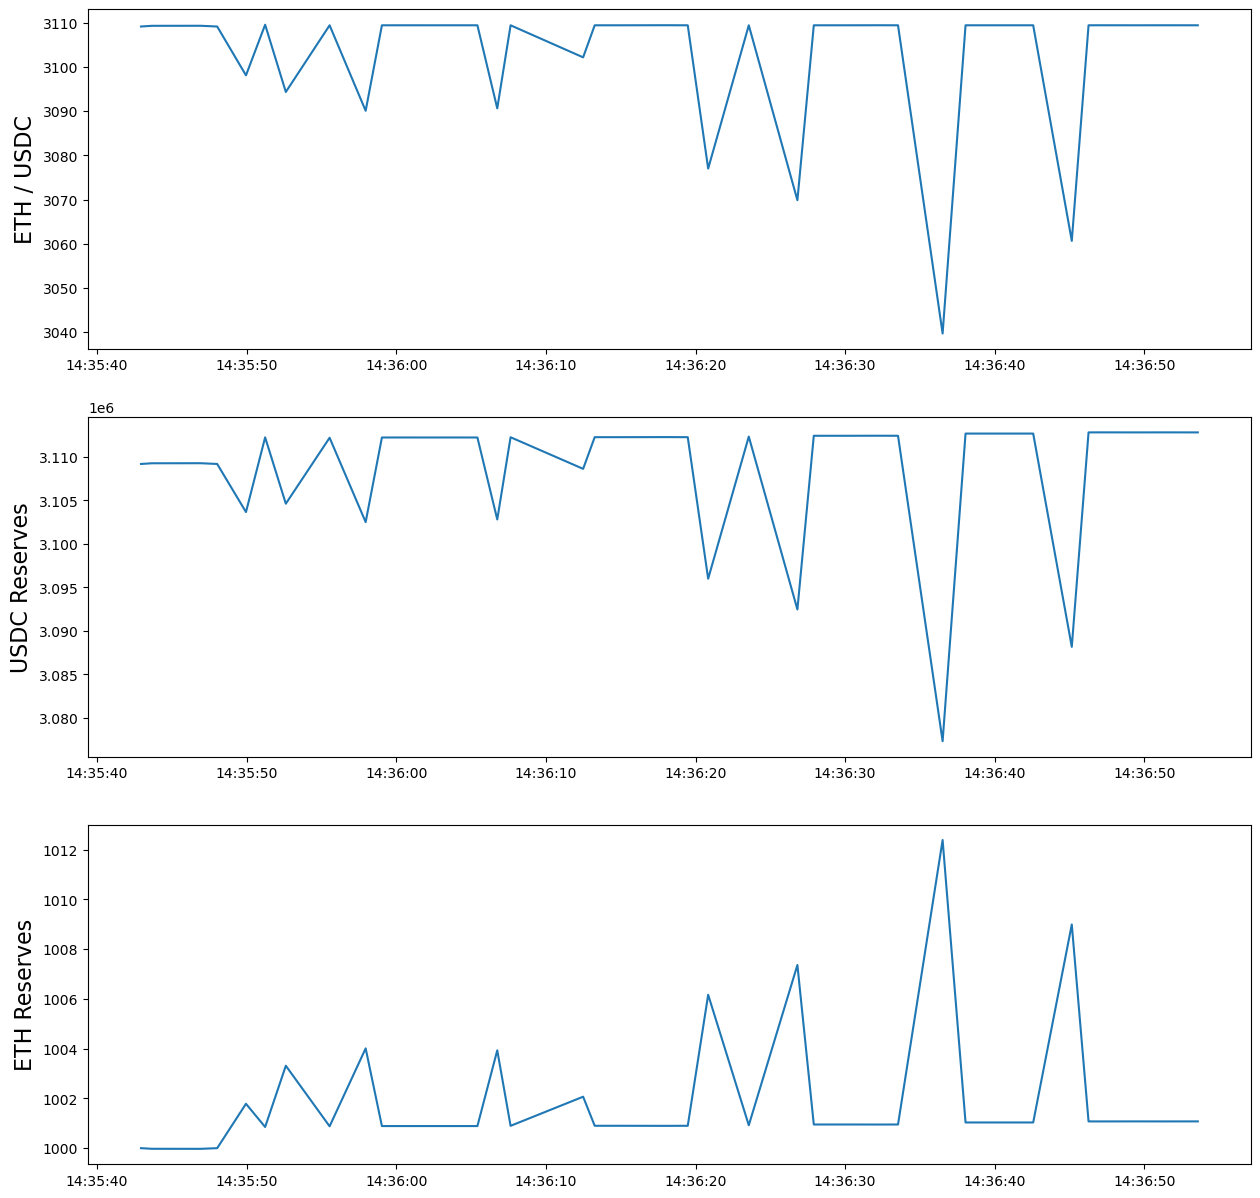

In [5]:
fig, (p_ax, tkn1_ax, tkn2_ax) = plt.subplots(nrows=3, sharex=False, sharey=False, figsize=(15, 15))
p_ax.plot(tstamp, lp_price_arr)
p_ax.set_ylabel(f'{eth.token_name} / {tkn.token_name}', fontsize=16)

tkn1_ax.plot(tstamp, x_amt_arr)
tkn1_ax.set_ylabel(f'{tkn.token_name} Reserves', fontsize=16)

tkn2_ax.plot(tstamp, y_amt_arr)
tkn2_ax.set_ylabel(f'{eth.token_name} Reserves', fontsize=16)

### Plot Swap Model

Text(0.5, 0, 'ETH Swap Amount')

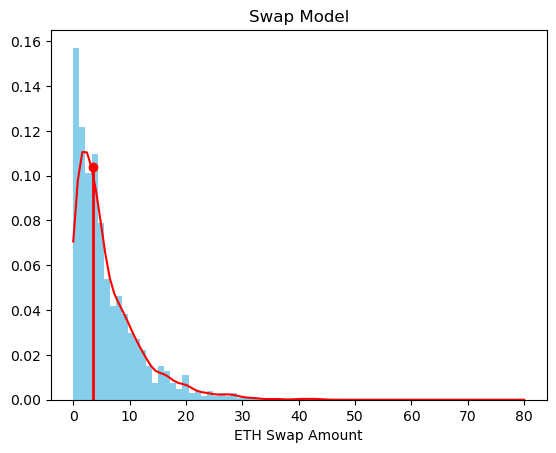

In [6]:
r_vals = [tdModel.delta() for k in range(1000)] 
dens = sm.nonparametric.KDEUnivariate(r_vals)
dens.fit()

x = np.linspace(0,80,100)
y = dens.evaluate(x)

#rsamp = tdModel.delta()
rind = random.randint(0, len(dens.icdf))
rsamp = dens.icdf[rind]

residuals = np.abs(x - rsamp)
ind = np.argmin(residuals, axis=0) 

plt.hist(r_vals, density=True, bins=40, color='skyblue')
plt.plot(x, y, 'r')
plt.plot([rsamp,rsamp], [0,y[ind]], 'r', linewidth=2)
plt.plot(rsamp,y[ind],'ro') 
plt.title(f'Swap Model') 
plt.xlabel(f'{eth.token_name} Swap Amount') 